<a href="https://colab.research.google.com/github/awagler2/NODE/blob/main/missing_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read in the merged data

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merged_full=pd.read_csv('/content/full_cip_Ed_Ex2.csv')
print(merged_full.shape)

<ipython-input-15-2e2954b66081>:1: DtypeWarning: Columns (26,29,30,169,207,389,479,480,481,483) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_full=pd.read_csv('/content/full_cip_Ed_Ex2.csv')


(126164, 508)
0         100654
1         100654
2         100654
3         100654
4         100654
           ...  
126159    494746
126160    494746
126161    493868
126162    493868
126163    493868
Name: unitid, Length: 126164, dtype: int64


In [ ]:
    #a few functions for finding missing values
    missing_values = merged_full.isnull().sum()
    missing_values.to_csv("missing_dist.csv", index=True)
    print(missing_values)

row_number                   0
unitid                       0
year_x                       0
inst_name                    0
longitude                    0
                          ... 
year                      1815
total_ft_undergrads       1815
hispanic_ft_undergrads    1815
hispanic_percent          1815
excellencia_hsi_status    1815
Length: 508, dtype: int64


In [ ]:
# Create the table
unitid_exp_total_table = merged_full[['unitid', 'exp_total']]

# Display the table (optional)
unitid_exp_total_table

#save to a CSV file (optional)
unitid_exp_total_table.to_csv('unitid_exp_total.csv', index=False)


In [ ]:
def carry_forward_impute(df, id_col, value_cols):
    """Imputes missing values using a carry-forward method for multiple columns.

    Args:
        df: DataFrame with the data.
        id_col: Name of the ID column.
        value_cols: List of names of the value columns to impute.

    Returns:
        DataFrame with imputed values.
    """
    df_imputed = df.copy()
    for id_val in df[id_col].unique():
        # Get the subset of data for the current ID
        subset = df[df[id_col] == id_val]

        # Iterate over each value column
        for value_col in value_cols:
            # Find the indices of missing values within the subset
            missing_indices = subset[value_col].isnull()

            # Carry forward the last valid value
            last_valid = np.nan
            for i, is_missing in enumerate(missing_indices):
                if not is_missing:
                    last_valid = subset[value_col].iloc[i]
                elif not pd.isna(last_valid):
                    df_imputed.loc[subset.index[i], value_col] = last_valid

    return df_imputed

all_columns_full = merged_full.columns.tolist()
all_columns_full.remove('unitid')
#print(all_columns_full)

# Example usage with a list of columns
subset_variables = ['cc_basic_2000', 'cc_undergrad_2015', 'rev_appropriations_fed', 'rev_appropriations_state', 'rev_grants_contracts_federal', 'rev_grants_contracts_state', 'exp_instruc_total', 'exp_research_total', 'exp_student_serv_total', 'exp_total_current', 'endowment_beg', 'exp_total']  # List the variables you want to keep
filtered_columns = [col for col in all_columns_full if col in subset_variables]

print(filtered_columns)
merged_imputed = carry_forward_impute(merged_full, 'unitid', filtered_columns)
#merged_full_imputed = carry_forward_impute(merged_full, 'unitid', all_columns_full)
# Verify imputation
#print(merged_full_imputed.isnull().sum())
# Assuming 'filtered_columns' contains the columns you want to replace
for column in filtered_columns:
    merged_full[column] = merged_imputed[column]



['cc_basic_2000', 'cc_undergrad_2015', 'rev_appropriations_fed', 'rev_appropriations_state', 'rev_grants_contracts_federal', 'rev_grants_contracts_state', 'exp_instruc_total', 'exp_research_total', 'exp_student_serv_total', 'exp_total_current', 'endowment_beg', 'exp_total']


In [ ]:
# Further processing or saving the imputed DataFrame
merged_full.to_csv('full_imputed.csv', index=False)
#merged_full_imputed.to_csv('merged_full_imputed.csv', index=False)

In [ ]:
# Filter for missing values in 'exp_total'
#this actually includes all missing (even when a institution has some non-missing)
missing_exp_total = merged_imputed[merged_imputed['exp_total'].isnull()]

# Group by 'unitid' and filter for groups with all missing values
unitids_with_all_missing = unitid_exp_total_table.groupby('unitid').filter(lambda group: group['exp_total'].isnull().all())

# Extract unique 'unitid' values
unitids_with_no_exp_total = unitids_with_all_missing['unitid'].unique()

# Print the result
#print(unitids_with_no_exp_total)

In [ ]:
# Create indicator variables for missing values
indicator_vars = merged_imputed.isnull().astype(int)

# Rename columns for clarity
indicator_vars = indicator_vars.add_prefix('missing_')

# Concatenate the two DataFrames horizontally (column-wise).
combined_data = pd.concat([merged_imputed, indicator_vars], axis=1)

selected_data = combined_data[['exp_total', 'missing_exp_total']]

                   exp_total  missing_exp_total
exp_total                1.0                NaN
missing_exp_total        NaN                1.0


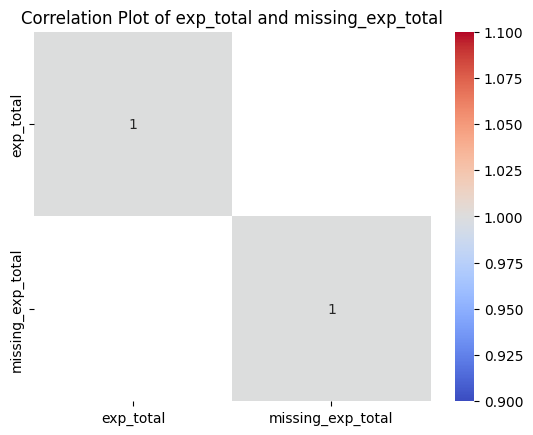

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = selected_data.corr(method="pearson",numeric_only=True)
print(correlation_matrix)
# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot of exp_total and missing_exp_total')
plt.show()

In [ ]:
# prompt: Using dataframe unitid_exp_total_table: What proportion of the unitid_exp_total_table has missing values for exp_total

# Calculate the proportion of missing values in the 'exp_total' column.
missing_proportion = unitid_exp_total_table['exp_total'].isnull().sum() / len(unitid_exp_total_table)

# Print the result.
missing_proportion


np.float64(0.421248288006261)

<Figure size 640x480 with 0 Axes>

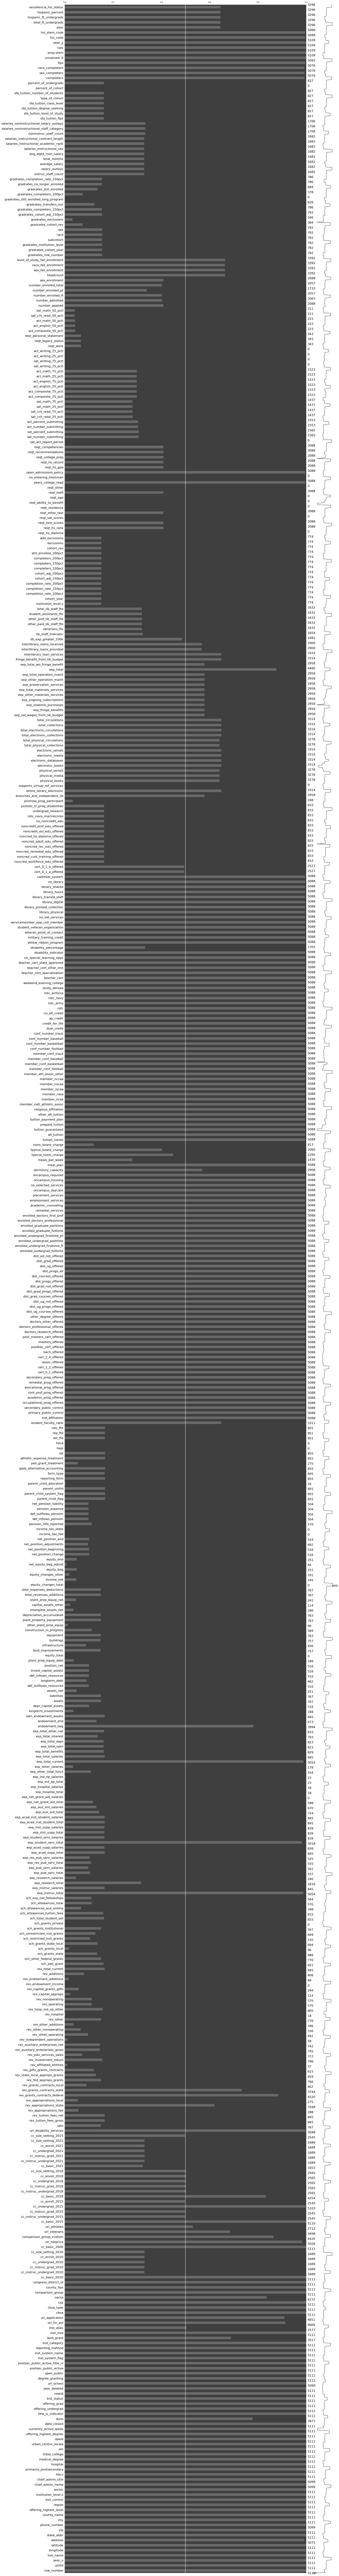

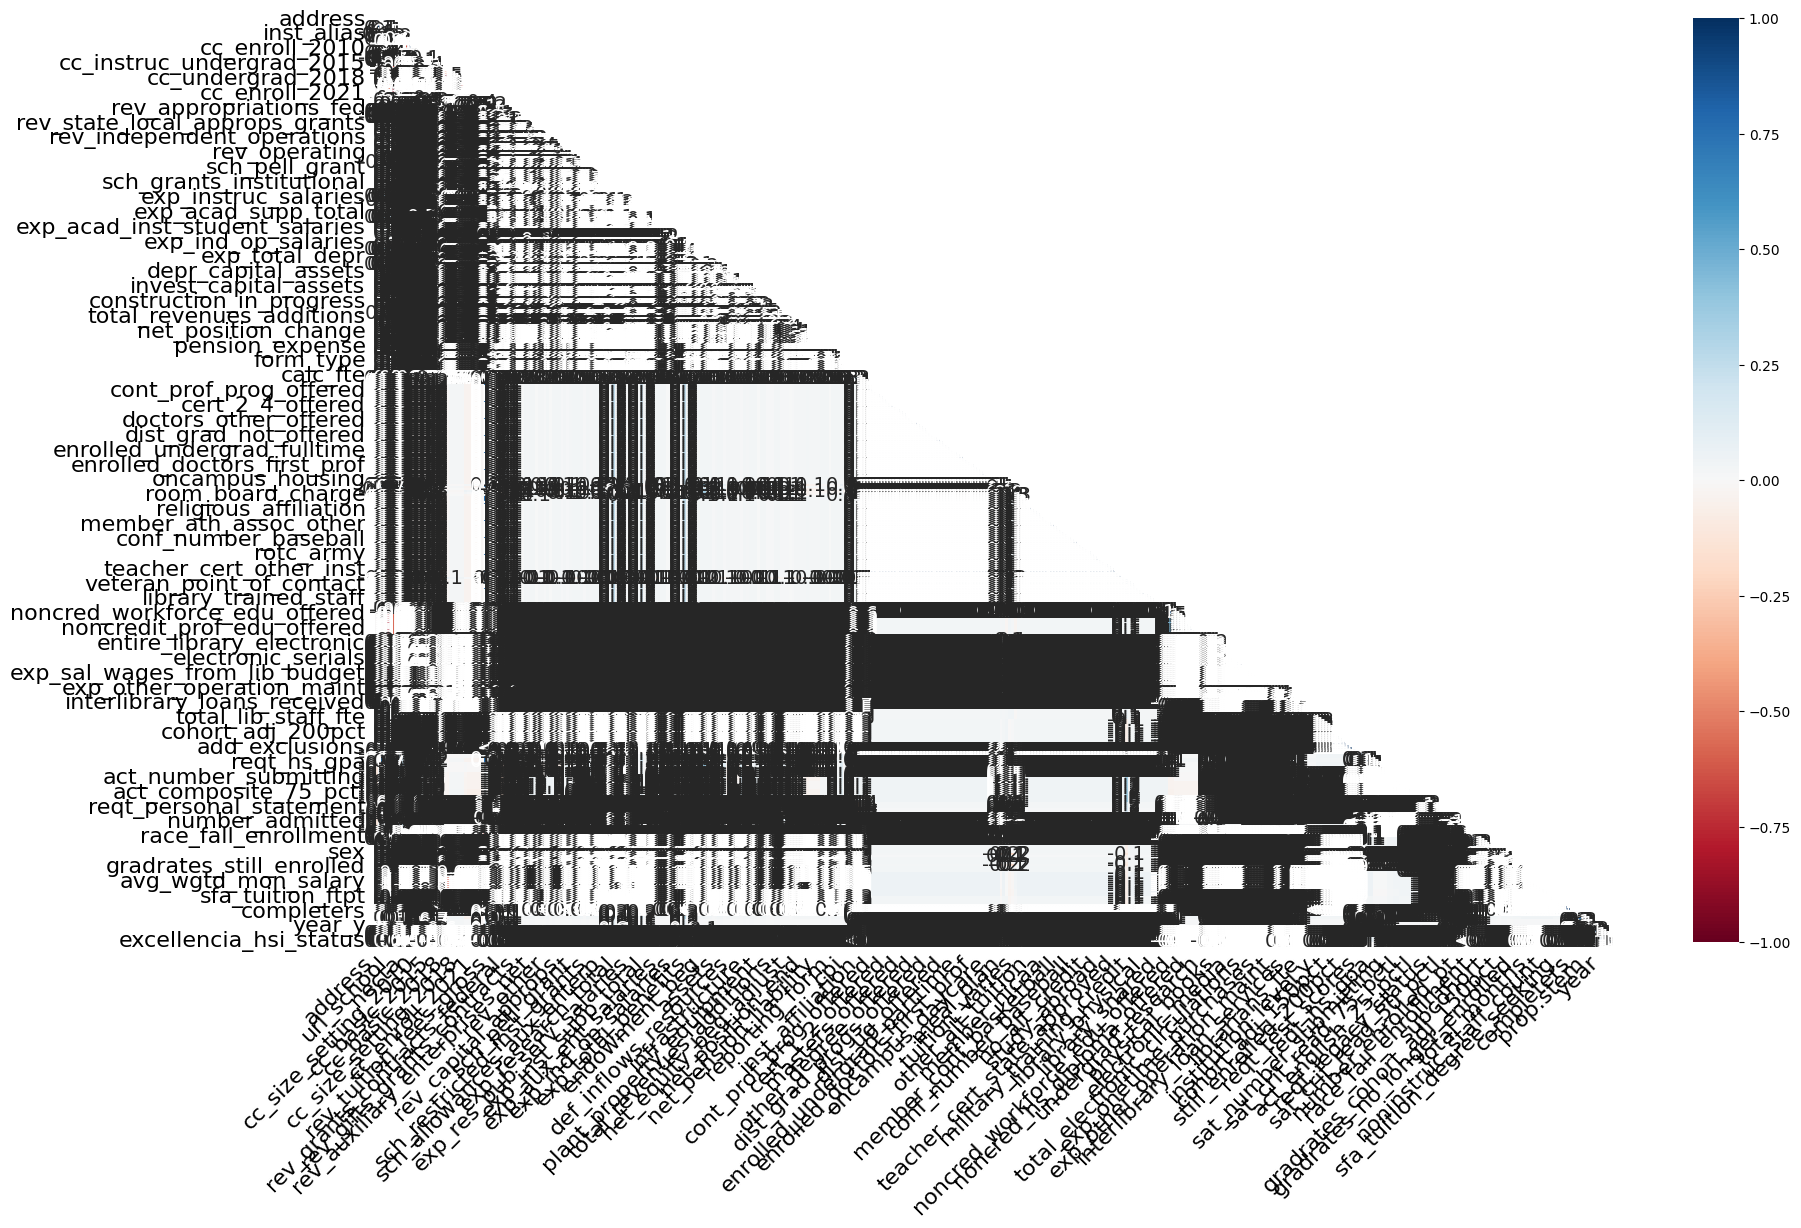

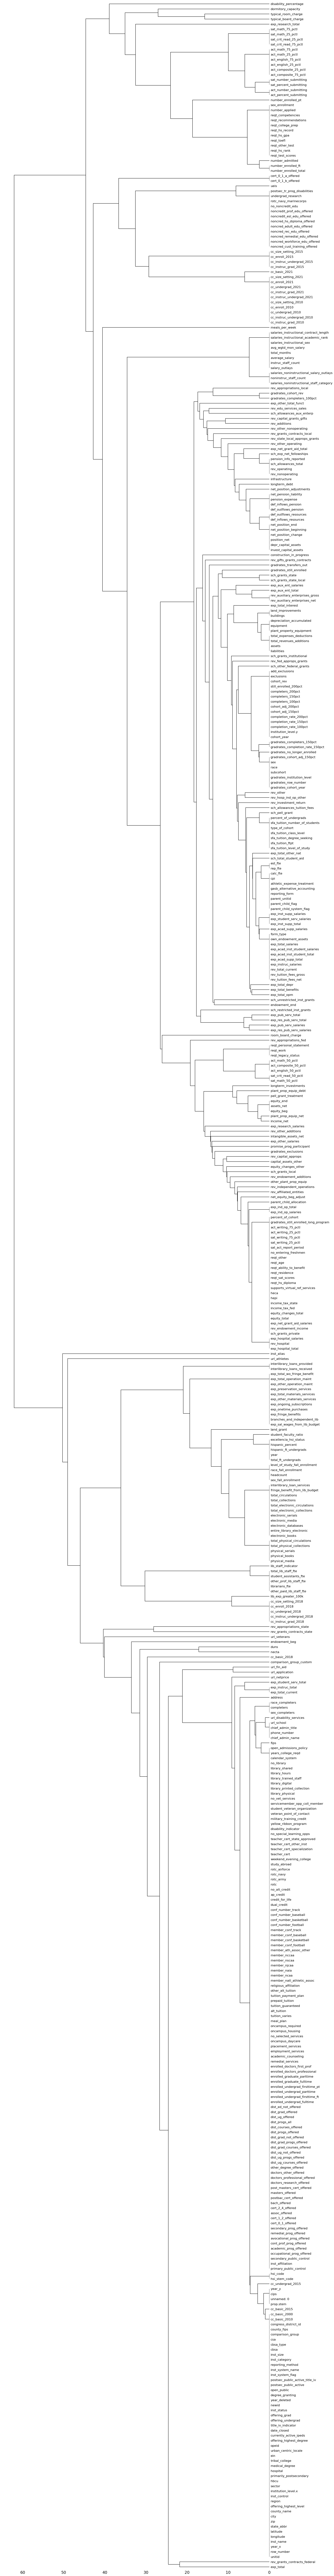

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get the current figure before creating the plots
fig = plt.gcf()

mat = msno.matrix(merged_imputed)  # Example: Matrix plot
bar = msno.bar(merged_imputed)  # Example: Bar plot
heat = msno.heatmap(merged_imputed) # Example: Heatmap
dendo = msno.dendrogram(merged_imputed) # Example: Dendrogram

# Now save the entire figure using fig.savefig()
fig.savefig("matrix_plot.png")

# Get a new figure for the next plot
fig = plt.figure()
bar.figure.savefig("bar_plot.png")  # Save the figure associated with the bar plot

fig = plt.figure()
heat.figure.savefig("heatmap_plot.png")  # Save the figure associated with the heatmap plot

fig = plt.figure()
dendo.figure.savefig("dendrogram_plot.png")  # Save the figure associated with the dendrogram plot

In [ ]:
def calculate_missingness_distances(df):
    """
    Calculates the variable-wise and subject-wise missingness distances
    for a given Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
                           Missing values should be represented as NaN.

    Returns:
        tuple: A tuple containing two distance matrices:
               - variable_missingness_distance (pd.DataFrame):
                 DataFrame with variable-wise missingness distances.
               - subject_missingness_distance (pd.DataFrame):
                 DataFrame with subject-wise missingness distances.
    """
    # 1. Create the missingness matrix M
    missingness_matrix = df.isnull().astype(int)

    # 2. Calculate Variable-wise Missingness Distance (Dv) [1]
    # The number of variables is the number of columns in the DataFrame
    num_variables = missingness_matrix.shape[1]  # Changed from shape[2] to shape[1]
    variable_missingness_distance = pd.DataFrame(
        np.zeros((num_variables, num_variables)),
        index=df.columns,
        columns=df.columns
    )

    for j_idx, j_col in enumerate(df.columns):
        for j_prime_idx, j_prime_col in enumerate(df.columns):
            if j_idx < j_prime_idx:
                # Proportion of discordant missingness indicators [1]
                discordant_count = np.sum(missingness_matrix[j_col] != missingness_matrix[j_prime_col])
                distance = discordant_count / len(df)
                variable_missingness_distance.loc[j_col, j_prime_col] = distance
                variable_missingness_distance.loc[j_prime_col, j_col] = distance
            elif j_idx == j_prime_idx:
                variable_missingness_distance.loc[j_col, j_prime_col] = 0.0

    # 3. Calculate Subject-wise Missingness Distance (Ds) [3]
    # num_subjects is the number of rows in the DataFrame
    num_subjects = missingness_matrix.shape[0]  # Changed to shape[0] to get the number of rows
    subject_missingness_distance = pd.DataFrame(
        np.zeros((num_subjects, num_subjects)),
        index=df.index,
        columns=df.index
    )

    for i_idx, i_row in enumerate(df.index):
        for i_prime_idx, i_prime_row in enumerate(df.index):
            if i_idx < i_prime_idx:
                # Proportion of discordant missingness indicators [3]
                discordant_count = np.sum(missingness_matrix.loc[i_row] != missingness_matrix.loc[i_prime_row])
                distance = discordant_count / num_variables
                subject_missingness_distance.loc[i_row, i_prime_row] = distance
                subject_missingness_distance.loc[i_prime_row, i_row] = distance
            elif i_idx == i_prime_idx:
                subject_missingness_distance.loc[i_row, i_prime_row] = 0.0

    return variable_missingness_distance, subject_missingness_distance